# Predicting Apartment Prices in Mexico City

In this project, I will predict the prices of apartments in Mexico City (Distrito Federal)

In [5]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

## Data Import, Cleaning and Preparation

There are 5 different csv files for this project. I will import one of them, clean it, add all the cleaning steps to a function, and apply the function to the rest of the csv files.

In [6]:
# Import csv file and inspect it
df1 = pd.read_csv('/workspaces/Predicting-Apartment-Prices-in-Mexico-City/mexico-city-real-estate-1.csv')
display(df1.head())
display(df1.info())

,Unnamed: 0,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
0,1,sell,apartment,|Miguel Hidalgo|Distrito Federal|México|,"23.634501,-102.552788",5500000.0,MXN,5450245.50,289775.66,NaN,54.0,NaN,101851.851900,NaN,NaN,NaN,http://miguel-hidalgo-df.properati.com.mx/o3zb...
1,2,sell,house,|Iztapalapa|Distrito Federal|México|,"19.31033,-99.068557",1512000.0,MXN,1498321.97,79661.96,NaN,80.0,NaN,18900.000000,NaN,NaN,NaN,http://iztapalapa.properati.com.mx/q7t0_venta_...
2,3,sell,apartment,|Tlalpan|Distrito Federal|México|,"19.279771,-99.234597",926667.0,MXN,918284.00,48822.82,NaN,100.0,NaN,9266.670000,NaN,NaN,NaN,http://tlalpan.properati.com.mx/qbi4_venta_dep...
3,4,sell,apartment,|Miguel Hidalgo|Distrito Federal|México|,"23.634501,-102.552788",6410000.0,MXN,6352013.39,337720.36,NaN,135.0,NaN,47481.481480,NaN,NaN,NaN,http://miguel-hidalgo-df.properati.com.mx/opeq...
4,5,sell,apartment,|Benito Juárez|Quintana Roo|México|,"21.1902642,-86.8198375",875000.0,USD,16457437.50,875000.00,0.0,263.0,NaN,3326.996198,NaN,NaN,NaN,http://cancun.properati.com.mx/hg4t_venta_depa...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4628 entries, 0 to 4627
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  4628 non-null   int64  
 1   operation                   4628 non-null   object 
 2   property_type               4628 non-null   object 
 3   place_with_parent_names     4628 non-null   object 
 4   lat-lon                     4144 non-null   object 
 5   price                       4538 non-null   float64
 6   currency                    4538 non-null   object 
 7   price_aprox_local_currency  4538 non-null   float64
 8   price_aprox_usd             4538 non-null   float64
 9   surface_total_in_m2         1668 non-null   float64
 10  surface_covered_in_m2       4436 non-null   float64
 11  price_usd_per_m2            1150 non-null   float64
 12  price_per_m2                4249 non-null   float64
 13  floor                       291 n

None

Since I'm concerned with only the apartments in Mexico City - Distrito Federal, I will subset on the `property_type` and filter for apartments.

Also, I will subset on `place_with_parent_names` and filter for those that contain Distrito Federal

In [7]:
# Subset on properties that are apartments
apt_filter = df1['property_type'] == 'apartment'

# Subset on locations that contain Distrito Federal
state_filter = df1['place_with_parent_names'].str.contains('Distrito Federal')

# Apply the filters
df1 = df1[apt_filter & state_filter]

In [3]:
df1.describe()

,Unnamed: 0,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses
count,4628.000000,4.538000e+03,4.538000e+03,4.538000e+03,1668.000000,4436.000000,1150.000000,4.249000e+03,291.000000,136.000000,5.000000
mean,2314.500000,3.244360e+06,5.584709e+06,2.969247e+05,287.982614,206.896979,1861.083927,2.255890e+04,2.147766,2.617647,763.000000
std,1336.132853,5.055502e+06,1.257514e+07,6.685879e+05,1374.944319,1778.713741,2461.620240,7.644811e+04,0.623245,1.174159,1013.580288
min,1.000000,3.700000e+04,1.238692e+05,6.585810e+03,0.000000,0.000000,16.128514,2.123116e+01,1.000000,1.000000,15.000000
25%,1157.750000,9.200000e+05,1.189215e+06,6.322753e+04,0.000000,67.000000,715.577376,9.777778e+03,2.000000,2.000000,200.000000
50%,2314.500000,1.846666e+06,2.527531e+06,1.343824e+05,109.500000,100.000000,1385.871832,1.620000e+04,2.000000,2.000000,300.000000
75%,3471.250000,3.700000e+06,5.263110e+06,2.798261e+05,244.250000,205.000000,2331.213757,2.962963e+04,2.000000,3.000000,800.000000
max,4628.000000,1.600000e+08,3.776868e+08,2.008064e+07,40000.000000,113100.000000,44794.131000,4.750000e+06,5.000000,8.000000,2500.000000


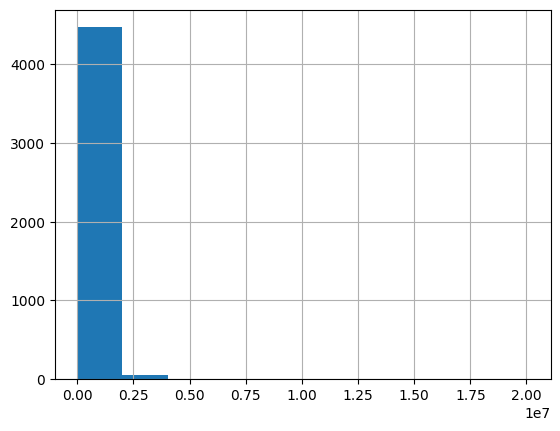

In [4]:
df1['price_aprox_usd'].hist();

In [5]:
df1.isna().sum()

Unnamed: 0                       0
operation                        0
property_type                    0
place_with_parent_names          0
lat-lon                        484
price                           90
currency                        90
price_aprox_local_currency      90
price_aprox_usd                 90
surface_total_in_m2           2960
surface_covered_in_m2          192
price_usd_per_m2              3478
price_per_m2                   379
floor                         4337
rooms                         4492
expenses                      4623
properati_url                    0
dtype: int64